## Evaluate Filtering - Indels in 8 WGS mutated lines and hybrid barley lines

Inspired by GATK's joint annotation plots of known vs novel variants and "A tour of scikit-allel" plotting.

Plots distributions of various annotations for.

### Setup

Add code block that allows multiple plots to "float around" and fit within window size

In [1]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [2]:
import numpy as np
from numpy import percentile
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)
from IPython.display import display_html

scikit-allel 1.3.5


---
### VCF filepath with custom annotations

VCF filepath with custom annotations for plotting
- `known_snp` vs `novel_snp`
- `filtered` vs `retained_filt1` vs `retained_filt2`

Custom annotations should be in a single file, please see the script `scikit_allel_plot_prep.sh` for how this VCF with custom annotations was generated.

In [3]:
fp_ann_h5 = "/panfs/jay/groups/9/morrellp/shared/Datasets/Alignments/mut8_and_hybrid_barley/Filtered/scikit_allel_files/ann_known_and_filt-mut8_and_hybrid_barley_indels.h5"


In [4]:
# Load data
callset = h5py.File(fp_ann_h5, mode='r')
callset

<HDF5 file "ann_known_and_filt-mut8_and_hybrid_barley_indels.h5" (mode r)>

In [5]:
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'QD', 'FS',
                                            'SOR', 'ReadPosRankSum', 'VAR_KNOWN', 'VAR_FILT'])
variants

<VariantChunkedTable shape=(5588435,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=447.7M cbytes=183.0M cratio=2.4
   values=h5py._hl.group.Group>

In [6]:
# Pull out only known SNPs
known_snps = variants.query('VAR_KNOWN == "known"')
known_snps

<VariantChunkedTable shape=(42,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=3.4K cbytes=2.1K cratio=1.6
   values=h5py._hl.files.File>

In [7]:
# Downsample novel variants for plotting purposes
novel_snps = variants.query('VAR_KNOWN == "novel"')[:][::200]
novel_snps

<VariantTable shape=(27942,) dtype=(numpy.record, [('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')])>
[('chr1H_part1',       249, 'T', ['TC', '', ''],  4380.45,  144, 25.36, 0.   , 2.933,    nan, 'novel', 'filtered')
 ('chr1H_part1',     46604, 'GT', ['G', '', ''], 24475.2 , 1049, 34.67, 3.184, 0.549, -0.481, 'novel', 'retained_filt1')
 ('chr1H_part1',     82563, 'CA', ['C', '', ''],   212.44, 1179,  7.59, 0.   , 0.976, -1.143, 'novel', 'retained_filt2')
 ...
 ('chr7H_part2', 303497822, 'TGTG', ['*', 'T', ''],   644.45,  501, 14.65, 5.029, 0.198,  0.   , 'novel', 'filtered')
 ('chr7H_part2', 303560438, 'TAATAG', ['T', '', ''],   106.92, 1098,  3.96, 0.   , 0.892, -0.114, 'novel', 'filtered')
 ('chr7H_part2', 303626158, 'T', ['TC', '', ''],   171.21, 1654,  3.98, 5.508, 1.529,  0.26 , 'novel', 'retained_filt1')]

In [8]:
# GATK's recommended Indel cutoffs
# Filter out QD < 2
qd_cutoff = 2

# Filter out FS > 200
fs_cutoff = 200

# Filter out SOR > 3
sor_cutoff = 3

# Filter out ReadPosRankSum < -8.0
readposranksum_cutoff = -20.0

---
### Summary stats

In [9]:
def summary_stats(x, f, low, high):
    minimum = np.min(x)
    maximum = np.max(x)
    avg = np.mean(x)
    dev = np.std(x)
    low_thresh = np.percentile(x, low)
    high_thresh = np.percentile(x, high)
    print("Given %d variants, we have the following stats for %s:\nMean: %f\
            \nMinimum: %f\nMaximum: %f\nSt. Deviation: %f\n%dth percentile: %f\n%dth percentile: %f\n"
          % (len(x), f, avg, minimum, maximum, dev, low, low_thresh, high, high_thresh))

In [10]:
# Summary of variants
# Remove nan values
qd = variants['QD'][:]
summary_stats(qd[~np.isnan(qd)], 'QD', 5, 95)
summary_stats(variants['FS'][:], 'FS', 5, 95)
summary_stats(variants['SOR'][:], 'SOR', 5, 95)
# Remove nan values
readposranksum = variants['ReadPosRankSum'][:]
summary_stats(readposranksum[~np.isnan(readposranksum)], 'ReadPosRankSum', 5, 95)

Given 5586972 variants, we have the following stats for QD:
Mean: 19.683096            
Minimum: 0.000000
Maximum: 43.150002
St. Deviation: 11.269535
5th percentile: 1.460000
95th percentile: 33.790001

Given 5588435 variants, we have the following stats for FS:
Mean: 6.935434            
Minimum: 0.000000
Maximum: 847.921021
St. Deviation: 15.114245
5th percentile: 0.000000
95th percentile: 29.320999

Given 5588435 variants, we have the following stats for SOR:
Mean: 1.260832            
Minimum: 0.000000
Maximum: 15.294000
St. Deviation: 1.219751
5th percentile: 0.245000
95th percentile: 3.912000

Given 4952446 variants, we have the following stats for ReadPosRankSum:
Mean: -0.069021            
Minimum: -23.389999
Maximum: 10.980000
St. Deviation: 1.180471
5th percentile: -2.189000
95th percentile: 1.680000



---
### Plot joint annotations

Compare known vs novel variants and each level of filtering.

In [11]:
def plot_known_vs_novel(novel_df, known_df, f1, f2, f1min, f1max, f2min, f2max, f1_cutoff, f2_cutoff):
    # Divide into filtered vs retained_filt1 vs retained_filt2
    # filtered
    novel_f1_filt = novel_df.query('VAR_FILT == "filtered"')[f1][:]
    novel_f2_filt = novel_df.query('VAR_FILT == "filtered"')[f2][:]
    # retained_filt1
    novel_f1_retfilt1 = novel_df.query('VAR_FILT == "retained_filt1"')[f1][:]
    novel_f2_retfilt1 = novel_df.query('VAR_FILT == "retained_filt1"')[f2][:]
    # retained_filt2
    novel_f1_retfilt2 = novel_df.query('VAR_FILT == "retained_filt2"')[f1][:]
    novel_f2_retfilt2 = novel_df.query('VAR_FILT == "retained_filt2"')[f2][:]
    
    fig, ax = plt.subplots()
    
    ax.scatter(novel_f1_filt, novel_f2_filt, c='#DAD7CD', alpha=0.2, label='Novel: filtered')
    ax.scatter(novel_f1_retfilt1, novel_f2_retfilt1, c='#8ECAE6', alpha=0.6, label='Novel: retained_filt1')
    ax.scatter(novel_f1_retfilt2, novel_f2_retfilt2, c='#126782', alpha=0.7, label='Novel: retained_filt2')
    #ax.scatter(known_f1, known_f2, c='#F4B266', alpha=0.9, label='Known')
    
    try:
        # filtered
        known_f1_filt = known_df.query('VAR_FILT == "filtered"')[f1][:]
        known_f2_filt = known_df.query('VAR_FILT == "filtered"')[f2][:]
        ax.scatter(known_f1_filt, known_f2_filt, c='#ffd07b', alpha=0.9, label='Known: filtered')
    except:
        pass
    
    try:
        # retained_filt1
        known_f1_retfilt1 = known_df.query('VAR_FILT == "retained_filt1"')[f1][:]
        known_f2_retfilt1 = known_df.query('VAR_FILT == "retained_filt1"')[f2][:]
        ax.scatter(known_f1_retfilt1, known_f2_retfilt1, c='#fd9e02', alpha=0.9, label='Known: retained_filt1')
    except:
        pass
    
    try:
        # retained_filt2
        known_f1_retfilt2 = known_df.query('VAR_FILT == "retained_filt2"')[f1][:]
        known_f2_retfilt2 = known_df.query('VAR_FILT == "retained_filt2"')[f2][:]
        ax.scatter(known_f1_retfilt2, known_f2_retfilt2, c='#b83700', alpha=0.6, label='Known: retained_filt2')
    except:
        pass
    
    ax.legend()
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s vs %s' % (f1, f2))
    
    # Add cutoff lines
    plt.axvline(x=f1_cutoff, color='#4A4A48', linewidth=0.6)
    plt.axhline(y=f2_cutoff, color='#4A4A48', linewidth=0.6)
    
    # Set axes range
    plt.xlim(f1min, f1max)
    plt.ylim(f2min, f2max)

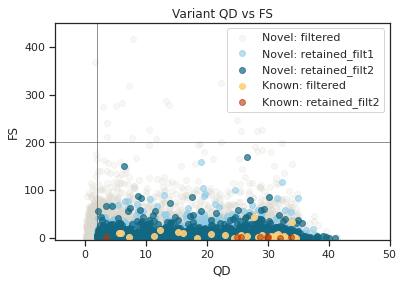

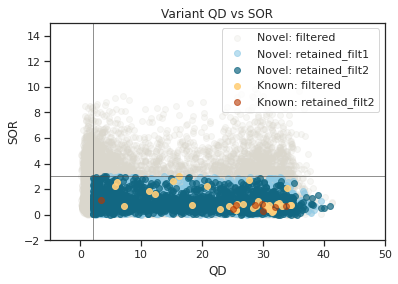

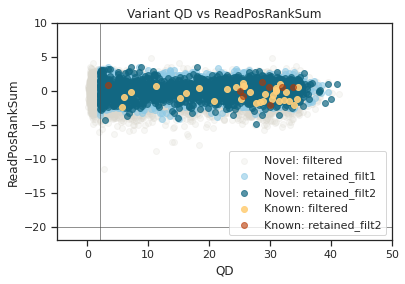

In [12]:
# Idea is to get a sense of the distributions
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='FS', f1min=-5, f1max=50, f2min=-5, f2max=450, f1_cutoff=qd_cutoff, f2_cutoff=fs_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='SOR', f1min=-5, f1max=50, f2min=-2, f2max=15, f1_cutoff=qd_cutoff, f2_cutoff=sor_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='QD', f2='ReadPosRankSum', f1min=-5, f1max=50, f2min=-22, f2max=10, f1_cutoff=qd_cutoff, f2_cutoff=readposranksum_cutoff)


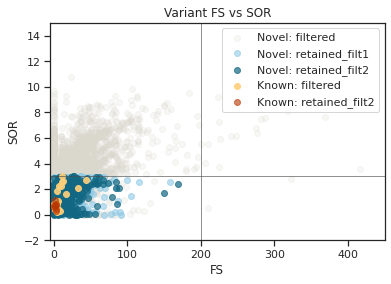

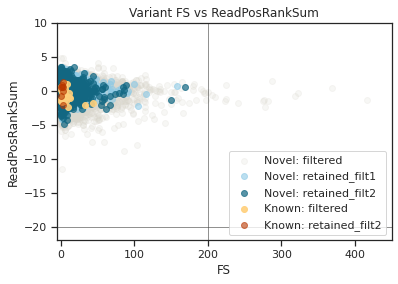

In [13]:
plot_known_vs_novel(novel_snps, known_snps, f1='FS', f2='SOR', f1min=-5, f1max=450, f2min=-2, f2max=15, f1_cutoff=fs_cutoff, f2_cutoff=sor_cutoff)
plot_known_vs_novel(novel_snps, known_snps, f1='FS', f2='ReadPosRankSum', f1min=-5, f1max=450, f2min=-22, f2max=10, f1_cutoff=fs_cutoff, f2_cutoff=readposranksum_cutoff)


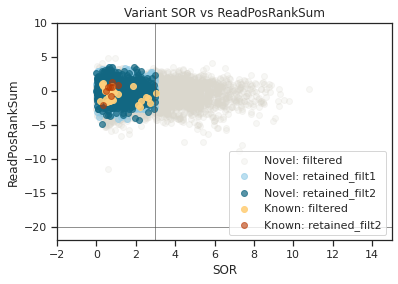

In [14]:
plot_known_vs_novel(novel_snps, known_snps, f1='SOR', f2='ReadPosRankSum', f1min=-2, f1max=15, f2min=-22, f2max=10, f1_cutoff=sor_cutoff, f2_cutoff=readposranksum_cutoff)


---
### Density plots of pass vs fail variants

In [15]:
# Prepare pass vs failed variants
# Pass (includes only "retained_filt2" ann)
pass_variants = variants.query('VAR_FILT == "retained_filt2"')
# Fail (includes "filtered" and "retained_filt1" ann)
fail_variants = variants.query('VAR_FILT != "retained_filt2"')

In [16]:
# Pass filt1 (includes "retained_filt1" and "retained_filt2" ann)
pass_filt1 = variants.query('VAR_FILT != "filtered"')
# Fail filt1 (only includes "filtered" ann)
fail_filt1 = variants.query('VAR_FILT == "filtered"')

In [17]:
def plot_pass_vs_fail(var_pass, var_fail, ann, ann_cutoff):
    # Separate into pass vs fail
    pass_var = var_pass[ann][:]
    fail_var = var_fail[ann][:]
    
    fig, ax = plt.subplots()
    
    sns.distplot(fail_var, hist=False, kde=True, 
         color = '#ff9b85',
         kde_kws={'shade': True, 'linewidth': 1},)
    sns.distplot(pass_var, hist=False, kde=True, 
         color = '#3ab795',
         kde_kws={'shade': True, 'linewidth': 1})
    
    plt.legend(["Fail", "Pass"])
    ax.set_xlabel(ann)
    ax.set_ylabel('Density')
    ax.set_title('Variant %s, pass vs failed' % (ann))
    
    # Add cutoff line
    plt.axvline(x=ann_cutoff, color='#4A4A48', linewidth=0.6)

Pass vs Fail variants after filtering pass 1.

In [18]:
print("For reference, here are GATK's recommended hard cutoffs.")
print("Variants fail filtering if:")
print("QD < ", qd_cutoff, "; FS > ", fs_cutoff, "; SOR > ", sor_cutoff, "; ReadPosRankSum < ", readposranksum_cutoff)

For reference, here are GATK's recommended hard cutoffs.
Variants fail filtering if:
QD <  2 ; FS >  200 ; SOR >  3 ; ReadPosRankSum <  -20.0


Pass vs Fail variants after filtering pass 1.

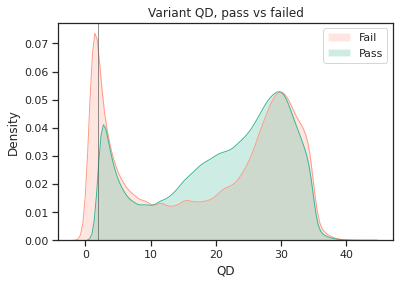

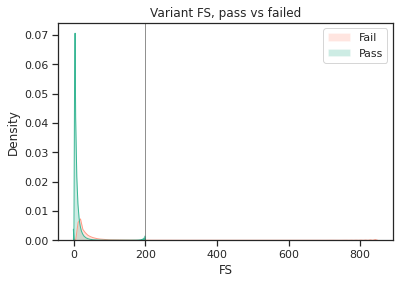

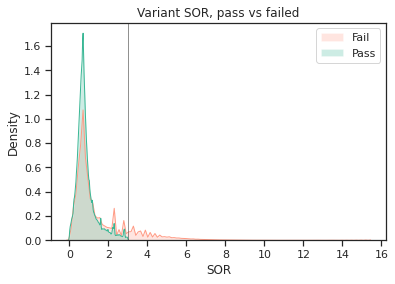

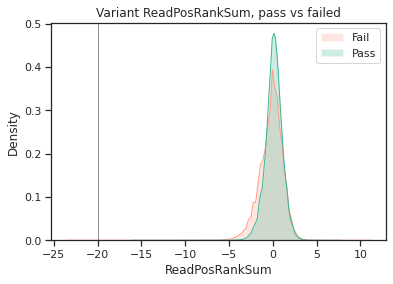

In [19]:
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='QD', ann_cutoff=qd_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='FS', ann_cutoff=fs_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='SOR', ann_cutoff=sor_cutoff)
plot_pass_vs_fail(pass_filt1, fail_filt1, ann='ReadPosRankSum', ann_cutoff=readposranksum_cutoff)

Pass vs fail filtering after pass 2.

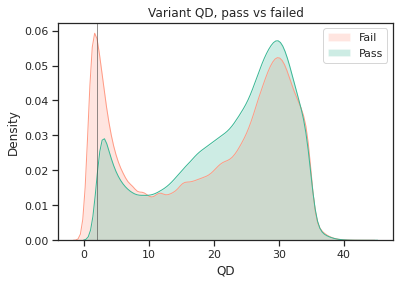

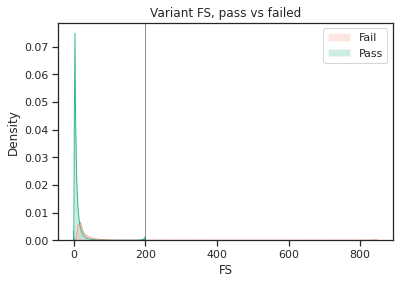

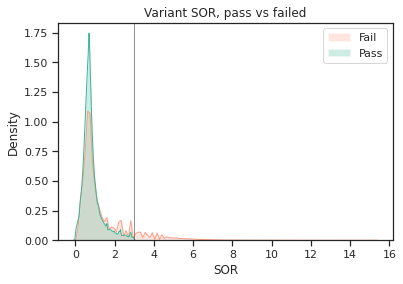

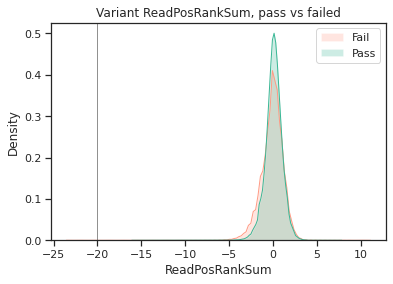

In [20]:
plot_pass_vs_fail(pass_variants, fail_variants, ann='QD', ann_cutoff=qd_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='FS', ann_cutoff=fs_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='SOR', ann_cutoff=sor_cutoff)
plot_pass_vs_fail(pass_variants, fail_variants, ann='ReadPosRankSum', ann_cutoff=readposranksum_cutoff)

In [21]:
known_filtered = variants.query('VAR_KNOWN == "known"').query('VAR_FILT == "filtered"')

In [22]:
known_filtered

<VariantChunkedTable shape=(34,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('QD', '<f4'), ('FS', '<f4'), ('SOR', '<f4'), ('ReadPosRankSum', '<f4'), ('VAR_KNOWN', 'O'), ('VAR_FILT', 'O')]
   nbytes=2.8K cbytes=1.7K cratio=1.7
   values=h5py._hl.files.File>

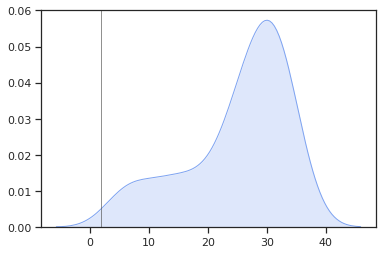

In [23]:
sns.distplot(known_filtered['QD'][:], hist=False, kde=True, 
         color = '#7ea3f1',
         kde_kws={'shade': True, 'linewidth': 1},)
plt.axvline(x=qd_cutoff, color='#4A4A48', linewidth=0.6)

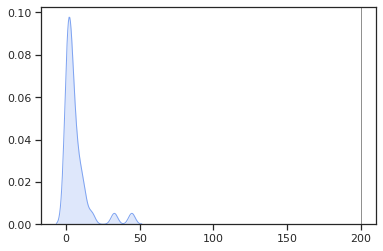

In [24]:
sns.distplot(known_filtered['FS'][:], hist=False, kde=True, 
         color = '#7ea3f1',
         kde_kws={'shade': True, 'linewidth': 1},)
plt.axvline(x=fs_cutoff, color='#4A4A48', linewidth=0.6)

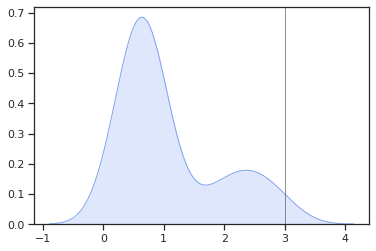

In [25]:
sns.distplot(known_filtered['SOR'][:], hist=False, kde=True, 
         color = '#7ea3f1',
         kde_kws={'shade': True, 'linewidth': 1},)
plt.axvline(x=sor_cutoff, color='#4A4A48', linewidth=0.6)

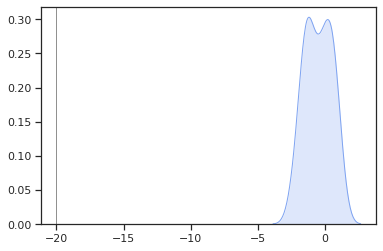

In [26]:
sns.distplot(known_filtered['ReadPosRankSum'][:], hist=False, kde=True, 
         color = '#7ea3f1',
         kde_kws={'shade': True, 'linewidth': 1},)
plt.axvline(x=readposranksum_cutoff, color='#4A4A48', linewidth=0.6)